## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# https://drive.google.com/file/d/1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0/view?usp=drive_link
!gdown 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0

Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=c38ff9ae-b132-41cd-a732-be415adc6aff
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:11<00:00, 51.1MB/s]


In [ ]:
!unzip img_cls_weather_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: weather-dataset/dataset/frost/3922.jpg  
  inflating: weather-dataset/dataset/frost/3923.jpg  
  inflating: weather-dataset/dataset/frost/3924.jpg  
  inflating: weather-dataset/dataset/frost/3925.jpg  
  inflating: weather-dataset/dataset/frost/3926.jpg  
  inflating: weather-dataset/dataset/frost/3927.jpg  
  inflating: weather-dataset/dataset/frost/3928.jpg  
  inflating: weather-dataset/dataset/frost/3929.jpg  
  inflating: weather-dataset/dataset/frost/3930.jpg  
  inflating: weather-dataset/dataset/frost/3931.jpg  
  inflating: weather-dataset/dataset/frost/3932.jpg  
  inflating: weather-dataset/dataset/frost/3933.jpg  
  inflating: weather-dataset/dataset/frost/3934.jpg  
  inflating: weather-dataset/dataset/frost/3935.jpg  
  inflating: weather-dataset/dataset/frost/3936.jpg  
  inflating: weather-dataset/dataset/frost/3937.jpg  
  inflating: weather-dataset/dataset/frost/3938.jpg  
  inflating: weather-dataset/da

## **1. Import libraries**

In [ ]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timm
from torch.optim.lr_scheduler import LambdaLR

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**

In [ ]:
root_dir = 'weather-dataset/dataset'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

## **3. Train, val, test split**

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

## **4. Create pytorch dataset**

In [ ]:
class WeatherDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

## **5. Create data preprocessing function**

In [ ]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

## **6. Create dataloader**

In [ ]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [ ]:
train_batch_size = 256
test_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([256, 3, 224, 224])
Labels batch shape: torch.Size([256])


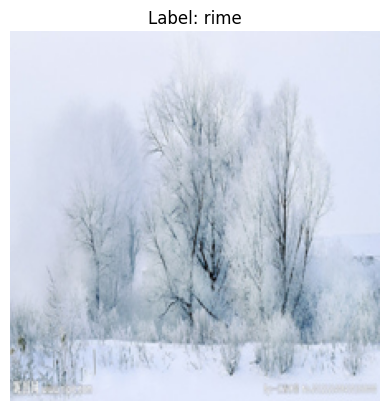

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [ ]:
classes

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

## **7. Create model**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)

        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride=1)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)

        return block_sequential


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [ ]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

teacher_model = timm.create_model(
    'resnet34',
    pretrained=True,
    num_classes=n_classes
).to(device)

student_model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
teacher_model.eval()
student_model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    teacher_output = teacher_model(dummy_tensor)
    student_output = student_model(dummy_tensor)


print('Teacher output shape:', teacher_output.shape)
print('Student output shape:', student_output.shape)

Teacher output shape: torch.Size([1, 11])
Student output shape: torch.Size([1, 11])


## **8. Training**

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [ ]:
def fit(
    teacher,
    student,
    T,
    soft_target_loss_weight,
    ce_loss_weight,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []
    val_accs = []
    teacher.eval()

    for epoch in range(epochs):
        batch_train_losses = []

        student.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)
            student_logits = student(inputs)

            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)
            label_loss = criterion(student_logits, labels)

            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            student, val_loader,
            criterion, device
        )
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        scheduler.step()

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc:.4f}')

    return train_losses, val_losses, val_accs

In [ ]:
lr = 1e-2
epochs = 30

def lr_lambda(epoch, warmup_epochs=5, total_epochs=30, init_scale=0.1, min_scale=0.3):
    scale_range = 1.0 - min_scale

    if epoch < warmup_epochs:
        warmup_factor = epoch / warmup_epochs
        return init_scale + (1.0 - init_scale) * warmup_factor

    decay_factor = (total_epochs - epoch) / (total_epochs - warmup_epochs)
    return min_scale + scale_range * max(0.0, decay_factor)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    student_model.parameters(),
    lr=lr
)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [ ]:
for epoch in range(epochs):
    print(f'Epoch {epoch}, LR: {lr * lr_lambda(epoch):.6f}')

Epoch 0, LR: 0.001000
Epoch 1, LR: 0.002800
Epoch 2, LR: 0.004600
Epoch 3, LR: 0.006400
Epoch 4, LR: 0.008200
Epoch 5, LR: 0.010000
Epoch 6, LR: 0.009720
Epoch 7, LR: 0.009440
Epoch 8, LR: 0.009160
Epoch 9, LR: 0.008880
Epoch 10, LR: 0.008600
Epoch 11, LR: 0.008320
Epoch 12, LR: 0.008040
Epoch 13, LR: 0.007760
Epoch 14, LR: 0.007480
Epoch 15, LR: 0.007200
Epoch 16, LR: 0.006920
Epoch 17, LR: 0.006640
Epoch 18, LR: 0.006360
Epoch 19, LR: 0.006080
Epoch 20, LR: 0.005800
Epoch 21, LR: 0.005520
Epoch 22, LR: 0.005240
Epoch 23, LR: 0.004960
Epoch 24, LR: 0.004680
Epoch 25, LR: 0.004400
Epoch 26, LR: 0.004120
Epoch 27, LR: 0.003840
Epoch 28, LR: 0.003560
Epoch 29, LR: 0.003280


In [ ]:
train_losses, val_losses, val_accs = fit(
    teacher_model,
    student_model,
    2,
    0.25,
    0.75,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.7321	Val loss: 2.3752	Val acc: 0.1122
EPOCH 2:	Train loss: 1.4854	Val loss: 2.1645	Val acc: 0.2353
EPOCH 3:	Train loss: 1.2879	Val loss: 1.6892	Val acc: 0.4530
EPOCH 4:	Train loss: 1.1751	Val loss: 1.4953	Val acc: 0.5266
EPOCH 5:	Train loss: 1.1112	Val loss: 1.3981	Val acc: 0.5827
EPOCH 6:	Train loss: 1.0616	Val loss: 1.3161	Val acc: 0.5972
EPOCH 7:	Train loss: 1.0267	Val loss: 1.2528	Val acc: 0.6351
EPOCH 8:	Train loss: 0.9903	Val loss: 1.9944	Val acc: 0.4268
EPOCH 9:	Train loss: 0.9616	Val loss: 1.2872	Val acc: 0.5994
EPOCH 10:	Train loss: 0.9285	Val loss: 1.6627	Val acc: 0.4865
EPOCH 11:	Train loss: 0.9061	Val loss: 1.1990	Val acc: 0.6562
EPOCH 12:	Train loss: 0.8806	Val loss: 1.3075	Val acc: 0.5936
EPOCH 13:	Train loss: 0.8584	Val loss: 1.0855	Val acc: 0.6686
EPOCH 14:	Train loss: 0.8479	Val loss: 1.4866	Val acc: 0.5266
EPOCH 15:	Train loss: 0.8221	Val loss: 1.0447	Val acc: 0.6977
EPOCH 16:	Train loss: 0.7965	Val loss: 1.2987	Val acc: 0.5645
EPOCH 17:	Train l

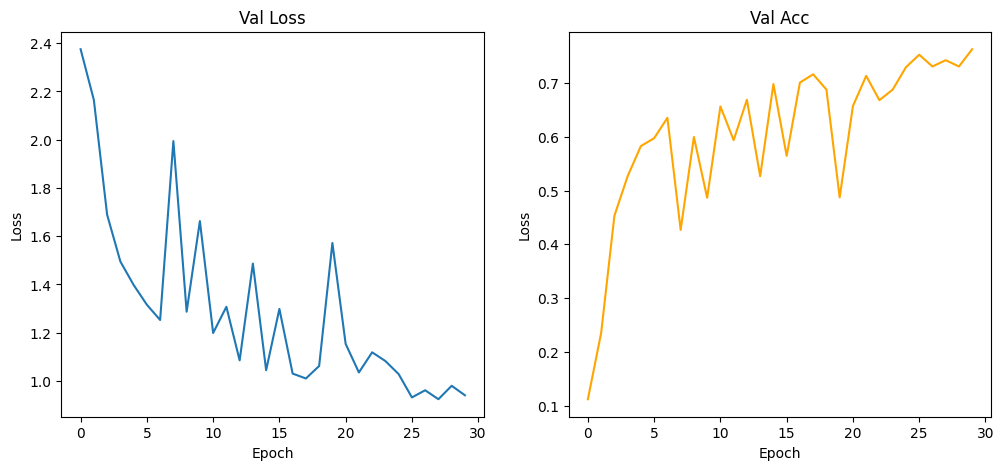

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(val_losses)
ax[0].set_title('Val Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_accs, color='orange')
ax[1].set_title('Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## **9. Evaluation**

In [ ]:
val_loss, val_acc = evaluate(
    student_model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    student_model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.7625637290604516
Test accuracy:  0.7671033478893741


## **10. Download the model**

In [ ]:
save_path = '/content/kdpretrained_wt.pt'
torch.save(student_model.state_dict(), save_path)